# Doing simple classification for DeepSky Datasets.

In [1]:
import numpy as np
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import cross_val_score
from sklearn import metrics
from sklearn.cross_validation import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.grid_search import GridSearchCV
from sklearn import svm
import matplotlib.pyplot as plt
import scipy.optimize as opt
import glob
import os
import sys
%matplotlib inline

In [2]:
#sys.modules[__name__].__dict__.clear()
#Function to read the files and put in the dataframe

def readData(path):
    allFiles = glob.glob(path)
    frame = pd.DataFrame()
    list_ = []
    
    for file_ in allFiles:
        #print file_
        df = pd.read_csv(file_,sep=r"\s+",header=None) #delim_whitespace=True
        list_.append(df)
        
    frame = pd.concat(list_)
    return frame;

In [4]:
#path = os.getcwd() + '/data/ex1data1.txt'

#path1 = r'/home/rbhat/S3Lab Project/DL_spectra/spectra_with_feature_*.txt'
#path2 = r'/home/rbhat/S3Lab Project/DL_spectra/spectra_without_feature_*.txt'

path1 = r'/home/rbhat/S3Lab Project/SubsetData/spectra_with_feature_*.txt'
path2 = r'/home/rbhat/S3Lab Project/SubsetData/spectra_without_feature_*.txt'
frame1 = readData(path1)
frame2 = readData(path2)

frame1.columns = ['X1', 'X2']
frame2.columns = ['X1', 'X2']
print frame1.head()

          X1        X2
0  3570.2613  3.171825
1  3571.9058 -0.058379
2  3572.7284  2.533114
3  3573.5511  0.774756
4  3574.3741  0.373932

[5 rows x 2 columns]


In [5]:
print frame1.shape, frame2.shape
Y1 = np.ones((frame1.shape[0],1))
frame1['Y'] = Y1

Y2 = np.zeros((frame2.shape[0],1))
frame2['Y'] = Y2

print Y1.shape
print frame1.head()
print frame1.shape

(142994, 2) (142994, 2)
(142994, 1)
          X1        X2  Y
0  3570.2613  3.171825  1
1  3571.9058 -0.058379  1
2  3572.7284  2.533114  1
3  3573.5511  0.774756  1
4  3574.3741  0.373932  1

[5 rows x 3 columns]
(142994, 3)


In [10]:
#print frame1[9210:9229], frame2[9210:9229]
print Y2.shape
print frame2.head()
print frame2.shape

(142994, 1)
          X1        X2  Y
0  3583.4389  5.368597  0
1  3584.2641  5.437156  0
2  3585.0895  9.573576  0
3  3585.9151  5.819682  0
4  3586.7409  7.228429  0

[5 rows x 3 columns]
(142994, 3)


Since plotting all data, the kernel is dead. I am plotting subset of data. It is same

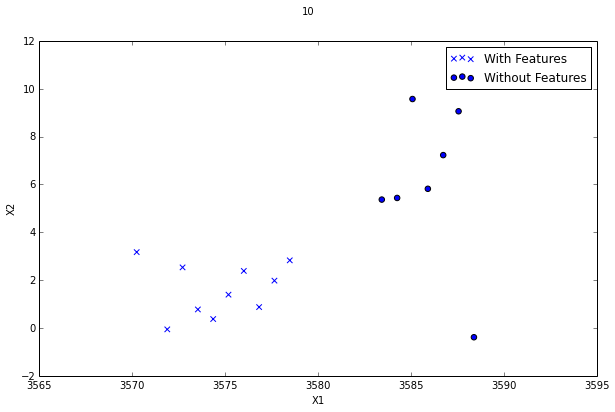

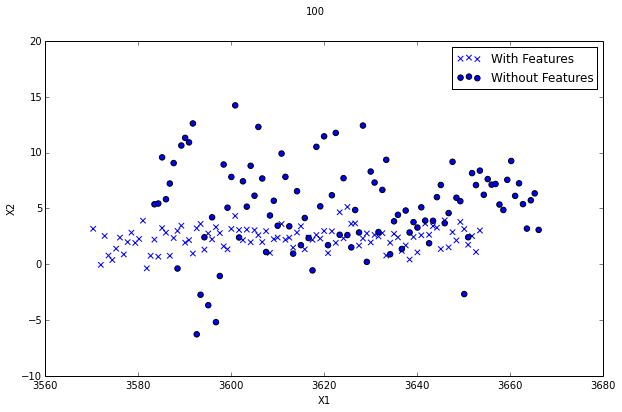

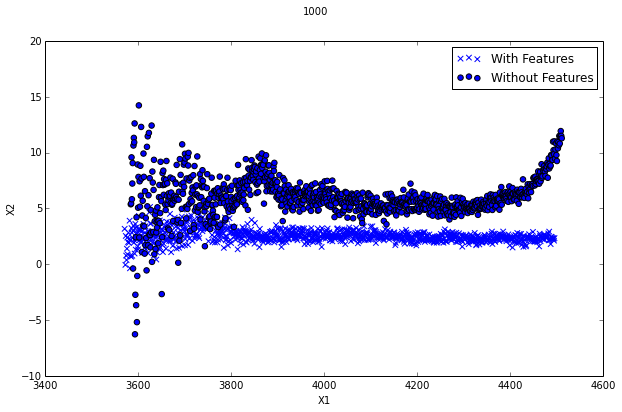

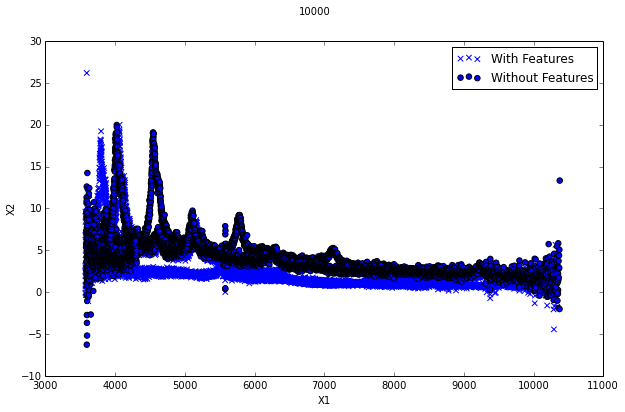

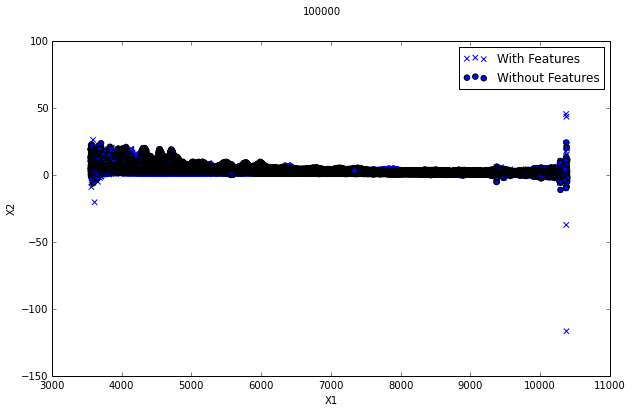

In [40]:
#frame1[0:5][0]
#Scatter plot of the data..
n = [10, 100, 1000, 10000, 100000]
for i in n:
    fig, ax = plt.subplots(figsize=(10,6))
    ax.scatter(frame1['X1'][0:i], frame1['X2'][0:i], s=30, marker='x', label='With Features')
    ax.scatter(frame2['X1'][0:i], frame2['X2'][0:i], s=30, marker='o', label='Without Features')
    ax.legend()
    ax.set_xlabel('X1')
    ax.set_ylabel('X2')
    fig.suptitle(i)

In [12]:
#Looks like there is memory error on concanation and permutation because of data size. So I will take subset of 
#data. Probabily take some 60% of data.
'''
print frame1.shape[0]
n = int(frame1.shape[0]*0.3)
print n

frame11 = frame1[0:n]
frame22 = frame2[0:n]
'''

'\nprint frame1.shape[0]\nn = int(frame1.shape[0]*0.3)\nprint n\n\nframe11 = frame1[0:n]\nframe22 = frame2[0:n]\n'

In [14]:
#Combine 2 data frame and reshuffle the data randomly
#ignore_index=True will make sure it will index serially.
frame = pd.concat([frame1, frame2], ignore_index=True)

#Reshuffle the data randomly
frame = frame.reindex(np.random.permutation(frame.index))
#frame.reset_index()

print frame.shape
print frame.head()

(285988, 3)
                X1         X2  Y
228531   6295.0618   5.219602  0
154117   5578.2760   1.125776  0
161293  10032.2880   1.032402  0
240697   4325.1383  15.276622  0
255884   5964.8565   4.092365  0

[5 rows x 3 columns]


Now splitting data in training and testing for classification purpose. We split 70% for training set and 30% for testing set. After that we do classification on the given astronomy datasets.

In [15]:
#Splitting the data for classification purpose..
#Input dataframe consists of X1, X2
X = frame[['X1','X2']]

#Output vector(predictor/response) vector
Y = frame['Y']

#Splitting data into train and testing. 70% Training and 30% Testing..
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=4)

In [17]:
print X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

#Validating the number
#print 101390*0.7, 101390*0.3 

(200191, 2) (200191,) (85797, 2) (85797,)


Some of the algorithm for logistic regression. Algorithm from Andrew Ng machine learning class.

## Logistic Regression

In [18]:
#Logistic Regression algorithm

#Sigmoid function
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

#Prediction
def predict(theta, X):
    probability = sigmoid(X * theta.T)
    return [1 if x >= 0.5 else 0 for x in probability]

#Cost calculation with regularization
def costReg(theta, X, y, learningRate):
    theta = np.matrix(theta)
    X = np.matrix(X)
    y = np.matrix(y)
    
    #print X.shape, y.shape, theta.shape
    
    first = np.multiply(-y, np.log(sigmoid(X * theta.T)))
    second = np.multiply((1 - y), np.log(1 - sigmoid(X * theta.T)))
    reg = (learningRate / 2 * len(X)) * np.sum(np.power(theta[:,1:theta.shape[1]], 2))
    return np.sum(first - second) / (len(X)) + reg
    
#Gradient calculation with regularization
def gradientReg(theta, X, y, learningRate):
    theta = np.matrix(theta)
    X = np.matrix(X)
    y = np.matrix(y)
    
    parameters = int(theta.ravel().shape[1])
    grad = np.zeros(parameters)
    
    error = sigmoid(X * theta.T) - y
    
    for i in range(parameters):
        term = np.multiply(error, X[:,i])
        
        if (i == 0):
            grad[i] = np.sum(term) / len(X)
        else:
            grad[i] = (np.sum(term) / len(X)) + ((learningRate / len(X)) * theta[:,i])
    
    return grad



In [19]:
# add a ones column - this makes the matrix multiplication work out easier
#print X.head()
#print Y.head()

X_tmp = X
Y_tmp = Y
print X_tmp.head()
X_tmp.insert(0,'Ones',1)
print X_tmp.head()

                X1         X2
228531   6295.0618   5.219602
154117   5578.2760   1.125776
161293  10032.2880   1.032402
240697   4325.1383  15.276622
255884   5964.8565   4.092365

[5 rows x 2 columns]
        Ones          X1         X2
228531     1   6295.0618   5.219602
154117     1   5578.2760   1.125776
161293     1  10032.2880   1.032402
240697     1   4325.1383  15.276622
255884     1   5964.8565   4.092365

[5 rows x 3 columns]


Since the optimization algorithm only uses ndarray type and no matrix type we need to change it to array. Also theta should be flatten other wise it gives wierd error.

In [20]:
X_tmp = np.array(X_tmp)
Y_tmp1 = np.matrix(Y_tmp)
Y_tmp = np.array(Y_tmp1.T)
theta_tmp = np.zeros(3)

print  X_tmp.shape, Y_tmp.shape, theta_tmp.shape
print type(X_tmp), type(Y_tmp), type(theta_tmp)

(285988, 3) (285988, 1) (3,)
<type 'numpy.ndarray'> <type 'numpy.ndarray'> <type 'numpy.ndarray'>


In [21]:

print costReg(theta_tmp, X_tmp, Y_tmp, 0)
    
print gradientReg(theta_tmp, X_tmp, Y_tmp, 0)

#Looks like fmin_tnc only take ndarray type, no matrix or whatsoever...
result = opt.fmin_tnc(func=costReg, x0=theta_tmp, fprime=gradientReg, args=(X_tmp,Y_tmp, 0) )
                                                                            
print result


0.693147180563
[  0.00000000e+00   3.68297206e-14   2.49789726e-01]
(array([  2.15550952e-01,   4.20320342e-05,  -1.66781164e-01]), 15, 1)


Now using the algorithm above, it calculates the accuracy. Accuracy seems bit low somehow.

In [22]:
#Accuracy
theta_min = np.matrix(result[0])
predictions = predict(theta_min, X_tmp)
correct = [1 if ((a == 1 and b == 1) or (a == 0 and b == 0)) else 0 for (a, b) in zip(predictions, Y_tmp)]
accuracy = (sum(map(int, correct)) / float(len(correct)))
#print 'accuracy = {0}%'.format(accuracy)
print 'accuracy = {0}%'.format(accuracy*100)

accuracy = 59.9846846721%


Now in below code, the polynomial feature is added for classification. This is done by taking polynomial power of each original column X1 & X2 and removing the original columns.

In [23]:
#Increasing the features..adding more polynomials term
degree = 5

#Reseting this variable
#%reset_selective frame_log
#%reset frame_log

frame_log = frame
x1 = frame_log['X1']
x2 = frame_log['X2']

print frame_log.head()
#print x1.head()
#print x2.head()

#Insert at 0th column, Ones column name and value as 1
frame_log.insert(3, 'Ones', 1) 
print frame_log.head()



                X1         X2  Y
228531   6295.0618   5.219602  0
154117   5578.2760   1.125776  0
161293  10032.2880   1.032402  0
240697   4325.1383  15.276622  0
255884   5964.8565   4.092365  0

[5 rows x 3 columns]
                X1         X2  Y  Ones
228531   6295.0618   5.219602  0     1
154117   5578.2760   1.125776  0     1
161293  10032.2880   1.032402  0     1
240697   4325.1383  15.276622  0     1
255884   5964.8565   4.092365  0     1

[5 rows x 4 columns]


In [24]:
for i in range(1, degree):
    for j in range(0, i):
        frame_log['X_' + str(i) + str(j)] = np.power(x1, i-j) * np.power(x2, j)

frame_log.drop('X1', axis=1, inplace=True)
frame_log.drop('X2', axis=1, inplace=True)

frame_log.head()

,Y,Ones,X_10,X_20,X_21,X_30,X_31,X_32,X_40,X_41,X_42,X_43
228531,0,1,6295.0618,3.962780e+07,32857.719050,2.494595e+11,2.068414e+08,171504.225926,1.570363e+15,1.302079e+12,1.079630e+09,895183.852102
154117,0,1,5578.2760,3.111716e+07,6279.887011,1.735801e+11,3.503094e+07,7069.743568,9.682778e+14,1.954123e+11,3.943698e+07,7958.944807
161293,0,1,10032.2880,1.006468e+08,10357.358209,1.009718e+12,1.039080e+08,10692.961472,1.012978e+16,1.042435e+12,1.072749e+08,11039.439087
240697,0,1,4325.1383,1.870682e+07,66073.502907,8.090959e+10,2.857770e+08,1009379.928123,3.499452e+14,1.236025e+12,4.365708e+09,15419915.616329
255884,0,1,5964.8565,3.557951e+07,24410.367585,2.122267e+11,1.456043e+08,99896.124177,1.265902e+15,8.685090e+11,5.958660e+08,408811.362257


In [25]:
# set X and y (remember from above that we moved the label to column 0)
cols = frame_log.shape[1]
X2 = frame_log.iloc[:,1:cols]
y2 = frame_log.iloc[:,0:1]

print X2.head()
print y2.head()

# convert to numpy arrays and initalize the parameter array theta
X2 = np.array(X2.values)
y2 = np.array(y2.values)
theta2 = np.zeros(11)


        Ones        X_10          X_20          X_21          X_30  \
228531     1   6295.0618  3.962780e+07  32857.719050  2.494595e+11   
154117     1   5578.2760  3.111716e+07   6279.887011  1.735801e+11   
161293     1  10032.2880  1.006468e+08  10357.358209  1.009718e+12   
240697     1   4325.1383  1.870682e+07  66073.502907  8.090959e+10   
255884     1   5964.8565  3.557951e+07  24410.367585  2.122267e+11   

                X_31            X_32          X_40          X_41  \
228531  2.068414e+08   171504.225926  1.570363e+15  1.302079e+12   
154117  3.503094e+07     7069.743568  9.682778e+14  1.954123e+11   
161293  1.039080e+08    10692.961472  1.012978e+16  1.042435e+12   
240697  2.857770e+08  1009379.928123  3.499452e+14  1.236025e+12   
255884  1.456043e+08    99896.124177  1.265902e+15  8.685090e+11   

                X_42             X_43  
228531  1.079630e+09    895183.852102  
154117  3.943698e+07      7958.944807  
161293  1.072749e+08     11039.439087  
240697  4.

In [26]:
print X2.shape, y2.shape, theta2.shape
print type(X2), type(y2), type(theta2)

(285988, 11) (285988, 1) (11,)
<type 'numpy.ndarray'> <type 'numpy.ndarray'> <type 'numpy.ndarray'>


In [27]:
learningRate = 1 #0.000001
print costReg(theta2, X2, y2, learningRate)
print gradientReg(theta2, X2, y2, learningRate)

0.693147180563
[  0.00000000e+00   3.68297206e-14   9.11822597e-12   1.36991193e+03
   4.78633876e-06   7.87212382e+06   1.09936057e+04  -3.51330301e-02
   4.75060811e+10   5.90362937e+07   8.27758228e+04]


In [28]:
#Not sure why all theta value is 0, search failed..????
result2 = opt.fmin_tnc(func=costReg, x0=theta2, fprime=gradientReg, args=(X2, y2, learningRate))
print result2
print opt.tnc.RCSTRINGS[4]

(array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]), 68, 4)
Linear search failed


In [29]:
theta_min = np.matrix(result2[0])
predictions = predict(theta_min, X2)
correct = [1 if ((a == 1 and b == 1) or (a == 0 and b == 0)) else 0 for (a, b) in zip(predictions, y2)]
accuracy = (sum(map(int, correct)) / float(len(correct)))
print 'accuracy = {0}%'.format(accuracy*100)

accuracy = 50.0%


## Logistic Regression (Sklearn)

In [30]:
#Logistic Regression-sklearn
logReg = LogisticRegression()
logReg.fit(X_train,Y_train)
Y_logPred = logReg.predict(X_test)
print metrics.accuracy_score(Y_test,Y_logPred)

0.646374581862


Confusion matrix of the model.

In [31]:
#Confusion matrix of logistic regression
conf = metrics.confusion_matrix(Y_test,Y_logPred)
#plt.imshow(conf)
print conf

[[27861 15016]
 [15324 27596]]


In [32]:
#Accuracy calculation other way..
(9453+9901)/float(9453+9901+5733+5330)

0.6362889173817273

## K-Neighbors 

In [33]:
# KNeighbours classification
knn = KNeighborsClassifier(n_neighbors=5)

knn.fit(X_train,Y_train)
Y_pred = knn.predict(X_test)
print metrics.accuracy_score(Y_test, Y_pred)
conf = metrics.confusion_matrix(Y_test, Y_pred)
#plt.imshow(conf)
print conf

0.613634509365
[[26174 16703]
 [16446 26474]]


In [34]:
(7776+8397)/float(7776+8397+7432+6812)

0.5317092415425584

## Random Forest

In [35]:
#Random Forest Classification
randForest = RandomForestClassifier(n_estimators=30)
randForest.fit(X_train,Y_train)
Y_randForestPred = randForest.predict(X_test)
print metrics.accuracy_score(Y_test,Y_randForestPred)

0.639066634031


In [36]:
#Confusion matrix for randomforest
conf2 = metrics.confusion_matrix(Y_test,Y_randForestPred)
#plt.imshow(conf2)
print conf2

[[28126 14751]
 [16216 26704]]


In [37]:
(9569+9086)/float(9569+9086+5639+6123)

0.613308347305783

## Support vector machine

In [38]:
#Support Vector Machine
svc = svm.LinearSVC(C=10, loss='hinge', max_iter=1000)
svc

LinearSVC(C=10, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='hinge', max_iter=1000, multi_class='ovr',
     penalty='l2', random_state=None, tol=0.0001, verbose=0)

In [39]:
svc.fit(X_train,Y_train)
svc.score(X_test, Y_test)

0.49977271932585055